In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import layers, regularizers, models, optimizers, losses, callbacks, metrics

2025-11-04 15:28:58.102151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 15:28:58.184843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762266538.203159    1337 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762266538.210083    1337 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762266538.284372    1337 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Columns
# has_diabetes: 0/1 (TARGET)
# age: integer
# sex: male/female
# hypertension: yes/no
# Enferemedad_vascular: yes/no
# Smoker: yes/no
# bmi: decimal
# Hba1c_cuan: decimal
# Hba1c_cual: normal/not normal
# random_glucose: decimal (maybe into cuantified/cualified setup)

## Entrenamiento del modelo

In [4]:
val_train_df = pd.read_csv('train_embeddings.csv', index_col=0)
test_df = pd.read_csv('test_embeddings.csv', index_col=0)
val_train_df.head()

,has_diabetes,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
patient_id,,,,,,,,,,,,,,,,,,,,,
82555,0,-0.038086,0.004242,0.002136,-0.012817,0.027954,0.049805,-0.034180,0.021362,0.020874,...,0.015076,0.037842,0.005890,0.057373,0.008362,-0.032959,-0.015076,0.044678,0.056885,0.005768
92299,0,-0.040039,-0.008545,0.002975,-0.022217,0.016235,0.064453,-0.071777,0.015198,-0.006256,...,-0.008240,0.028564,0.040527,0.034424,0.000000,-0.012146,-0.031982,0.000683,0.033203,0.010071
18725,0,-0.070801,-0.002518,0.001144,-0.003326,0.028931,0.007782,-0.061279,0.004883,-0.016724,...,-0.004456,-0.009766,0.010071,0.023804,0.003326,-0.034668,0.013977,0.026001,0.036133,-0.004547
52208,1,-0.079102,0.021851,0.003738,0.000205,-0.022949,0.061279,-0.062012,0.014282,0.010254,...,-0.020752,-0.000110,0.001900,0.031738,-0.028198,-0.011230,-0.034912,0.016968,0.030640,0.019775
2640,0,-0.056396,-0.000511,-0.000511,-0.007721,0.014954,0.063965,-0.073730,-0.000778,0.019043,...,-0.024780,0.031250,0.038330,0.037354,-0.028442,-0.020386,-0.052002,0.003464,0.022339,0.003128


In [5]:
val_df = val_train_df.sample(frac=0.2, random_state=42)
train_df = val_train_df.drop(val_df.index)

In [6]:
x_val = val_df.drop(columns=['has_diabetes'])
y_val = val_df['has_diabetes']
x_train = train_df.drop(columns=['has_diabetes'])
y_train = train_df['has_diabetes']

In [7]:
(x_train.iloc[0,:] ** 2).sum()

np.float64(0.9975264953946398)

In [8]:
# Autoencoder to reduce dimensionality of embeddings
x0 = layers.Input(shape=(1024,))
# Encoder
l_norm = 1e-6
encoded = layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(x0)
encoded = layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(encoded)
encoded = layers.Dense(128, activation='softmax', kernel_regularizer=regularizers.l2(l_norm))(encoded)
encoded = layers.Dense(64, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(encoded)
encoded = layers.Dense(32, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(encoded)
encoded = layers.Dense(16, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(encoded)
# Decoder
decoded = layers.Dense(32, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(encoded)
decoded = layers.Dense(64, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(decoded)
decoded = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(decoded)
decoded = layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(decoded)
decoded = layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(decoded)
decoded = layers.Dense(1024, activation='softmax', kernel_regularizer=regularizers.l2(l_norm))(decoded)
# Classifier to bias the embeddings
y_comp = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(encoded)
y_comp = layers.Dense(64, activation='swish', kernel_regularizer=regularizers.l2(l_norm))(y_comp)
y_comp = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l_norm))(y_comp)
autoencoder = models.Model(x0, [decoded, y_comp])
encoder = models.Model(x0, encoded)
autoencoder.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], loss_weights=[0.5, 0.5], metrics=['mse', 'accuracy'])
autoencoder.summary()

I0000 00:00:1762266541.810006    1337 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9704 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    524,800 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        544 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      2,112 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      8,320 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     33,024 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │      2,176 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    131,584 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1024)      │    525,312 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         65 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,411,281 (5.38 MB)

 Trainable params: 1,411,281 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
autoencoder.fit(x_train, [x_train, y_train.values.reshape(-1, 1)],
                epochs=100, batch_size=32,
                validation_split=0.2,
                callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
               ) 

Epoch 1/100


I0000 00:00:1762266546.681963    2975 service.cc:152] XLA service 0x7f4ccc005b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762266546.682001    2975 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-11-04 15:29:06.800956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762266547.362650    2975 cuda_dnn.cc:529] Loaded cuDNN version 91301


 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - dense_11_loss: 9.7735e-04 - dense_11_mse: 9.7735e-04 - dense_14_accuracy: 0.5931 - dense_14_loss: 0.6902 - loss: 0.3484

I0000 00:00:1762266549.157799    2975 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - dense_11_loss: 9.7715e-04 - dense_11_mse: 9.7715e-04 - dense_14_accuracy: 0.7042 - dense_14_loss: 0.6242 - loss: 0.3151 - val_dense_11_loss: 9.7736e-04 - val_dense_11_mse: 9.7736e-04 - val_dense_14_accuracy: 0.7354 - val_dense_14_loss: 0.5795 - val_loss: 0.2924
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - dense_11_loss: 9.7696e-04 - dense_11_mse: 9.7696e-04 - dense_14_accuracy: 0.7125 - dense_14_loss: 0.5509 - loss: 0.2779 - val_dense_11_loss: 9.7713e-04 - val_dense_11_mse: 9.7713e-04 - val_dense_14_accuracy: 0.8125 - val_dense_14_loss: 0.3844 - val_loss: 0.1946
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_11_loss: 9.7670e-04 - dense_11_mse: 9.7670e-04 - dense_14_accuracy: 0.8115 - dense_14_loss: 0.3996 - loss: 0.2021 - val_dense_11_loss: 9.7686e-04 - val_dense_11_mse: 9.7686e-04 - val_dense_14_accuracy: 0.8521 - val_dense_14_loss: 0.3205 - val_loss: 0.1625
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_11_l

In [10]:
x_train_encoded = encoder.predict(x_train)
x_val_encoded = encoder.predict(x_val)
x_test_encoded = encoder.predict(test_df)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [11]:
activation = 'swish'  # Funciona muy bien en general
l_norm = 1e-10
model = models.Sequential(layers=[
    layers.Input(shape=x_train_encoded.shape[1:]),
    layers.Dense(256, activation=activation, kernel_regularizer=regularizers.l2(l_norm)),
    layers.Dense(256, activation=activation, kernel_regularizer=regularizers.l2(l_norm)),
    layers.Dense(128, activation=activation, kernel_regularizer=regularizers.l2(l_norm)),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l_norm))
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,169 (403.00 KB)

 Trainable params: 103,169 (403.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(x_train_encoded, y_train.values.reshape(-1, 1), epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)])
print()
print('Training accuracy:', history.history['accuracy'][-1])
print()
print('Validation accuracy:', history.history['val_accuracy'][-1])

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8750 - loss: 0.6100 - val_accuracy: 0.8708 - val_loss: 0.5013
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8776 - loss: 0.3892 - val_accuracy: 0.8750 - val_loss: 0.3098
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8745 - loss: 0.2828 - val_accuracy: 0.8771 - val_loss: 0.2828
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8760 - loss: 0.2700 - val_accuracy: 0.8750 - val_loss: 0.2814
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8771 - loss: 0.2689 - val_accuracy: 0.8771 - val_loss: 0.2811
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8755 - loss: 0.2686 - val_accuracy: 0.8771 - val_loss: 0.2812
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8745 - loss: 0.2685 - val_accuracy: 0.8771 - val_loss: 0.2814
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.2687 - val_accuracy: 0.8771 - 

In [13]:
model.evaluate(x_val_encoded, y_val.values.reshape(-1, 1), batch_size=32)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8267 - loss: 0.4113


[0.4113224148750305, 0.8266666531562805]

In [15]:
y_val_pred = model.predict(x_val_encoded)
# Calculate f1-score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
y_val_pred_labels = (y_val_pred >= 0.5).astype(int)
f1 = f1_score(y_val, y_val_pred_labels)
print('F1-score:', f1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score: 0.7346938775510204


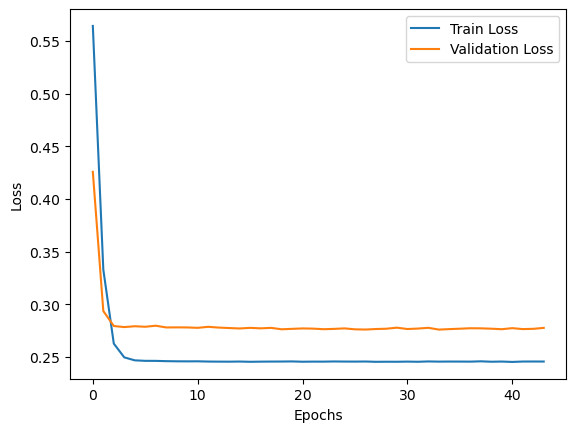

In [136]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Inferencia del modelo

In [ ]:
x_test = test_df.copy()
predictions = model.predict(x_test)
x_test['has_diabetes'] = (predictions >= 0.5).astype(int)
x_test[['has_diabetes']].to_csv('predictions.csv', index=True)